In [1]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import shutil
from zipfile import ZipFile 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from collections import Counter
from sklearn.model_selection import GridSearchCV

In [2]:
with ZipFile("train.zip", 'r') as zObject: 
    zObject.extractall( 
        path="data")

In [3]:
with ZipFile("test.zip", 'r') as zObject: 
    zObject.extractall( 
        path="data")

In [4]:
# Remove data that is not going to be used
shutil.rmtree('data/train/Blueberry leaf')
shutil.rmtree('data/train/Cherry leaf')
shutil.rmtree('data/train/Corn Gray leaf spot')
shutil.rmtree('data/train/Corn leaf blight')
shutil.rmtree('data/train/Corn rust leaf')
shutil.rmtree('data/train/Peach leaf')
shutil.rmtree('data/train/Potato leaf early blight')
shutil.rmtree('data/train/Potato leaf late blight')
shutil.rmtree('data/train/Raspberry leaf')
shutil.rmtree('data/train/Soyabean leaf')
shutil.rmtree('data/train/Squash Powdery mildew leaf')
shutil.rmtree('data/train/Strawberry leaf')
shutil.rmtree('data/train/Tomato two spotted spider mites leaf')

shutil.rmtree('data/test/Blueberry leaf')
shutil.rmtree('data/test/Cherry leaf')
shutil.rmtree('data/test/Corn Gray leaf spot')
shutil.rmtree('data/test/Corn leaf blight')
shutil.rmtree('data/test/Corn rust leaf')
shutil.rmtree('data/test/Peach leaf')
shutil.rmtree('data/test/Potato leaf early blight')
shutil.rmtree('data/test/Potato leaf late blight')
shutil.rmtree('data/test/Raspberry leaf')
shutil.rmtree('data/test/Soyabean leaf')
shutil.rmtree('data/test/Squash Powdery mildew leaf')
shutil.rmtree('data/test/Strawberry leaf')

In [5]:
#show an example training image
fig = plt.figure(figsize=(10, 7))

img_testy = []

img1 = cv2.imread('data/train/Apple leaf/20130519yellowingappleleaves.jpg') # Reads in BGR format
img_resized1 = cv2.resize(img1, (1400, 1000), interpolation=cv2.INTER_AREA)
img_gray1 = cv2.cvtColor(img_resized1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread('data/test/Apple leaf/20180511_091133-24l1vhg-e1526047988236.jpg')
img_resized2 = cv2.resize(img2, (1400, 1000), interpolation=cv2.INTER_AREA)
img_gray2 = cv2.cvtColor(img_resized2, cv2.COLOR_BGR2GRAY)

img3 = cv2.imread('data/test/Apple leaf/20180511_091252-1gy5xf5-e1526048000596.jpg')
img_resized3 = cv2.resize(img3, (1400, 1000), interpolation=cv2.INTER_AREA)
img_gray3 = cv2.cvtColor(img_resized3, cv2.COLOR_BGR2GRAY)

img4 = cv2.imread('data/test/Apple leaf/4120978-single-green-leaf-of-apple-tree.jpg')
img_resized4 = cv2.resize(img4, (1400, 1000), interpolation=cv2.INTER_AREA)
img_gray4 = cv2.cvtColor(img_resized4, cv2.COLOR_BGR2GRAY)
# img5 = cv2.imread('data/test/Apple leaf/apple-leaf-14319997.jpg')
# img6 = cv2.imread('data/test/Apple leaf/apple-leaf-9834637.jpg')
# img7 = cv2.imread('data/test/Apple leaf/apple-leaf-closeup-37636177.jpg')
# img8 = cv2.imread('data/test/Apple leaf/apple-leaf-isolated-white-background-56631026.jpg')
# img9 = cv2.imread('data/test/Apple leaf/Apple-Leaf-Wallpaper-17.jpg')
#img_resized = cv2.resize(img_rgb, (128, 128))
# img_resized = cv2.resize(img, (1400, 1000), interpolation=cv2.INTER_AREA)
# img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

img_testy.append(img_gray1)
img_testy.append(img_gray2)
img_testy.append(img_gray3)
img_testy.append(img_gray4)

<Figure size 1000x700 with 0 Axes>

In [6]:
img_testy[0]

array([[108, 108, 108, ...,  95,  95,  95],
       [108, 108, 108, ...,  95,  95,  95],
       [108, 108, 108, ...,  95,  95,  95],
       ...,
       [ 45,  45,  45, ..., 117, 117, 117],
       [ 45,  45,  45, ..., 117, 117, 117],
       [ 45,  45,  45, ..., 117, 117, 117]], dtype=uint8)

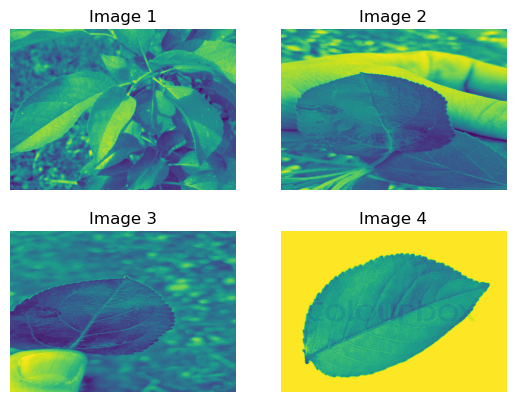

In [7]:
# Add the first image to the figure (top-left position)
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, first position
plt.imshow(img_testy[0])  
plt.axis('off')  # Hide the axis labels
plt.title("Image 1") 

# Add the second image to the figure (top-right position)
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, second position
plt.imshow(img_testy[1])  
plt.axis('off')  # Hide the axis labels
plt.title("Image 2") 

# Add the third image to the figure (bottom-left position)
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, third position
plt.imshow(img_testy[2]) 
plt.axis('off')  # Hide the axis labels
plt.title("Image 3")  
# Add the fourth image to the figure (bottom-right position)
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, fourth position
plt.imshow(img_testy[3])  
plt.axis('off')  # Hide the axis labels
plt.title("Image 4") 

#plt.imshow(img_gray)
plt.show()

In [8]:
def load_and_extract_features(directory):
    X = []
    y = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        label_name = label.split()[0]
        for filename in os.listdir(label_dir):
            image_path = os.path.join(label_dir, filename)
            # Load image using OpenCV
            img = cv2.imread(image_path)
            # Resize image to (128, 128)
            img_resized = cv2.resize(img, (128, 128))
            # Convert image to grayscale
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            # Calculate HOG features
            hog_features = extract_hog_features(img_gray)
            X.append(hog_features)
            y.append(label_name)
    return X, y


In [9]:
def extract_hog_features(image):
    # Calculate HOG features
    hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), visualize=False)
    return hog_features

In [10]:
train_X, train_y = load_and_extract_features('data/train')

In [11]:
train_X[0]

array([0.18577277, 0.24531249, 0.1394608 , ..., 0.08710288, 0.20978098,
       0.18921179])

In [12]:
train_y[0]

'Tomato'

In [13]:
len(train_X)

1136

In [14]:
print(np.unique(train_y))

['Apple' 'Bell_pepper' 'Tomato' 'grape']


In [15]:
print(Counter(train_y))

Counter({'Tomato': 671, 'Apple': 240, 'Bell_pepper': 115, 'grape': 110})


In [16]:
test_X, test_y = load_and_extract_features('data/test')

In [17]:
test_X[0]

array([0.10088811, 0.05351937, 0.08531351, ..., 0.2662169 , 0.14976733,
       0.06621507])

In [18]:
test_y[0]

'Tomato'

In [19]:
len(test_X)

135

In [20]:
print(np.unique(test_y))

['Apple' 'Bell_pepper' 'Tomato' 'grape']


In [21]:
print(Counter(test_y))

Counter({'Tomato': 69, 'Apple': 29, 'grape': 20, 'Bell_pepper': 17})


In [33]:

rf_classifier = RandomForestClassifier(n_estimators=100, max_features="sqrt", criterion='entropy', max_depth=3)
rf_classifier.fit(train_X, train_y)

RandomForestClassifier(criterion='entropy', max_depth=3)

In [34]:
y_pred = rf_classifier.predict(test_X)
rf_accuracy = accuracy_score(test_y, y_pred)

print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

       Apple       0.28      0.53      0.36        15
 Bell_pepper       0.00      0.00      0.00         0
      Tomato       1.00      0.57      0.73       120
       grape       0.00      0.00      0.00         0

    accuracy                           0.57       135
   macro avg       0.32      0.28      0.27       135
weighted avg       0.92      0.57      0.69       135



/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [25]:
print(y_pred)

['Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato'
 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato'
 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato'
 'Tomato' 'Tomato' 'Tomato' 'Apple' 'Tomato' 'Tomato' 'Tomato' 'Tomato'
 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato'
 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Apple' 'Tomato'
 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Apple'
 'Tomato' 'Tomato' 'Tomato' 'Apple' 'Tomato' 'Tomato' 'Tomato' 'Tomato'
 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato'
 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato'
 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Apple' 'Apple'
 'Tomato' 'Apple' 'Apple' 'Tomato' 'Tomato' 'Tomato' 'Apple' 'Tomato'
 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato'
 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Tomato' 'Apple' 'Apple

In [71]:
param_grid = {
    'n_estimators': [500, 1000],
    'max_features': ['sqrt'],
    'max_depth': [5, 7, 8],
    'criterion': ['gini', 'entropy']
}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(train_X, train_y)
print(grid_search.best_estimator_)